In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# load & understand data

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [3]:
df_train.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [4]:
print('train dataset :', df_train.shape)

train dataset : (45593, 20)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [7]:
df_train.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


## observation

In [8]:
for column in df_train.columns:
    print(column)
    print(df_train[column].value_counts())
    print("-----------------------------------")

ID
ID
0x4607     1
0x1f3e     1
0xe251     1
0x3f31     1
0x4a78     1
          ..
0xc3f1     1
0x5db7     1
0x1985     1
0xceda     1
0x5fb2     1
Name: count, Length: 45593, dtype: int64
-----------------------------------
Delivery_person_ID
Delivery_person_ID
PUNERES01DEL01     67
JAPRES11DEL02      67
HYDRES04DEL02      66
JAPRES03DEL01      66
VADRES11DEL02      66
                   ..
DEHRES18DEL03       7
AURGRES11DEL03      7
KOLRES09DEL03       6
KOCRES16DEL03       6
BHPRES010DEL03      5
Name: count, Length: 1320, dtype: int64
-----------------------------------
Delivery_person_Age
Delivery_person_Age
35      2262
36      2260
37      2227
30      2226
38      2219
24      2210
32      2202
22      2196
29      2191
33      2187
28      2179
25      2174
34      2166
26      2159
21      2153
27      2150
39      2144
20      2136
31      2120
23      2087
NaN     1854
50        53
15        38
Name: count, dtype: int64
-----------------------------------
Delivery_person_R

# data cleaning

In [9]:
def update_column_name(df):

    df.rename(columns={'Weatherconditions':'Weather_conditions'},inplace=True)

update_column_name(df_train)
print(df_train.columns)

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')


In [10]:
def extract_column_value(df):
    df['Time_Taken(mmin)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    df['City_code']=df['Delivery_person_ID'].str.split('RES',expand=True)[0]

extract_column_value(df_train)
df_train[['Time_taken(min)','Weather_conditions','City_code']].head()

,Time_taken(min),Weather_conditions,City_code
0,(min) 24,Sunny,INDO
1,(min) 33,Stormy,BANG
2,(min) 26,Sandstorms,BANG
3,(min) 21,Sunny,COIMB
4,(min) 30,Cloudy,CHEN


In [11]:
def convert_nan(df):
    df.replace('NaN',float(np.nan),regex=True,inplace=True)

convert_nan(df_train)

In [14]:
df_train.isnull().sum().sort_values(ascending=False)


Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Vehicle_condition                 0
Time_Taken(mmin)                  0
Time_taken(min)                   0
Type_of_vehicle                   0
Type_of_order                     0
ID                                0
Delivery_person_ID                0
Time_Order_picked                 0
Order_Date                        0
Delivery_location_longitude       0
Delivery_location_latitude        0
Restaurant_longitude              0
Restaurant_latitude               0
City_code                         0
dtype: int64

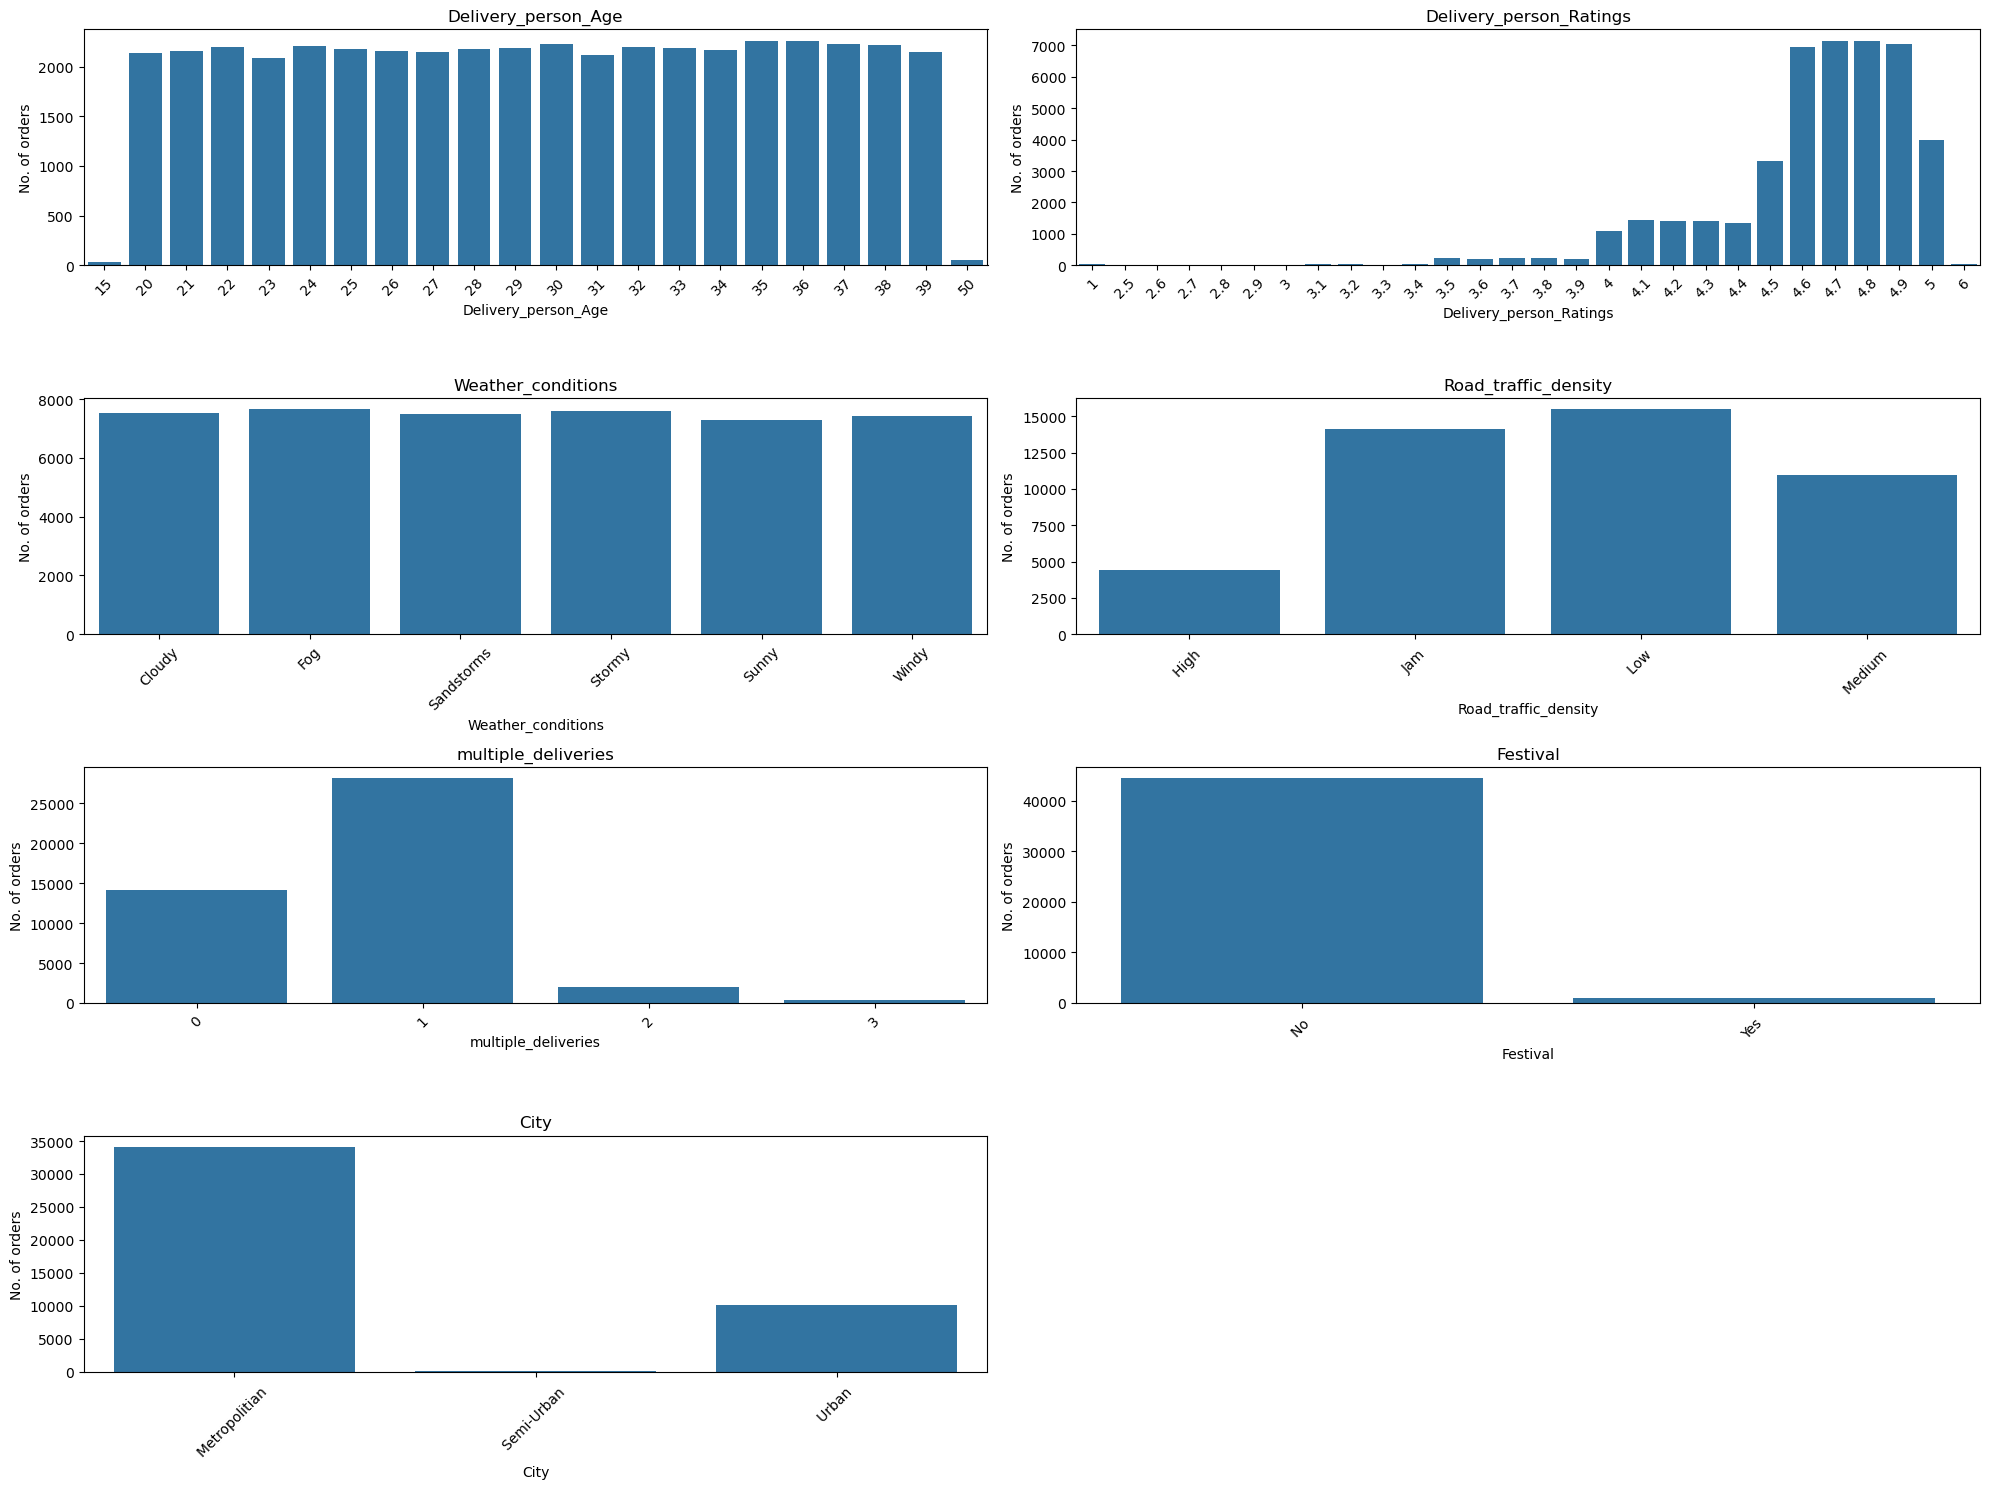

In [21]:
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weather_conditions','Road_traffic_density','multiple_deliveries','Festival','City']
# cols = ['Delivery_person_Age','Delivery_person_Ratings','Weather_conditions','Road_traffic_density','multiple_deliveries','Festival','City']

num_plots=len(cols)
num_rows=(num_plots // 2)+(num_plots % 2)

fig,axes = plt.subplots(num_rows,2,figsize=(20,15))

for i,column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row,col]
    sns.countplot(data=df_train,x=column_name,order=df_train[column_name].value_counts().sort_index().index,ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x',rotation=45)

if num_plots % 2 !=0:
    fig.delaxes(axes[-1,-1])

plt.tight_layout()
plt.show()